In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# importing data

def load_data():

    train = pd.read_csv("train.csv", parse_dates = [2],low_memory=False)#, index_col = 'Date')

    store = pd.read_csv("store.csv")

    test = pd.read_csv("test.csv", parse_dates = [3],low_memory=False)
    
    return train,store,test

train,store,test = load_data()

In [3]:
print(train.shape)
print(test.shape)
display(train.head(3),test.head(3))

(1017209, 9)
(41088, 8)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [4]:
print(store.shape)
store.head(1)

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [5]:
# find nulls
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


# DATA PREPERATION


In [4]:
def prep_na():

    #fill na with 0 

    store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
    store.fillna(0,inplace= True)

    #fill na with 1 = open  

    test.fillna(1,inplace= True)
    

def prep_data(dataframe):
    
    #dates
    dataframe['year'] = pd.DatetimeIndex(dataframe['Date']).year
    dataframe['month'] = pd.DatetimeIndex(dataframe['Date']).month
    dataframe['day'] = pd.DatetimeIndex(dataframe['Date']).day
    dataframe['week_of_year'] = pd.DatetimeIndex(dataframe['Date']).weekofyear
    dataframe['quarter'] = pd.DatetimeIndex(dataframe['Date']).quarter
    

#fill na
prep_na() 

prep_data(train)
prep_data(test)


# only open stores with sales
train = train[train["Open"] != 0]
train = train[train["Sales"] != 0]

# replace categorical numerical columns with numbers

store['StoreType'] = store['StoreType'].replace({ "a": 1, "b": 2, "c": 3,"d":4})
store['Assortment'] = store['Assortment'].replace({ "a": 1, "b": 2, "c": 3})
#train['StateHoliday'] = train['StateHoliday'].replace({"0":0, "a": 1, "b": 1, "c": 1})
train['StateHoliday'] = train['StateHoliday'].replace({"0":0, "a": 1, "b": 2, "c": 3})
test['StateHoliday'] = test['StateHoliday'].replace({"0":0, "a": 1, "b": 2, "c": 3})

# merge data with stores data

train_store = pd.merge(train, store, how = 'left', on = 'Store')
test_store = pd.merge(test, store, how = 'left', on = 'Store')

print("train : " +str(train.shape) ,"store : "+str(store.shape),"merged : " +str(train_store.shape))
print("test : " +str(train.shape) ,"store : "+str(store.shape),"merged : " +str(train_store.shape))

# fill na after merge 

train_store.fillna(0, inplace = True)
test_store.fillna(0, inplace = True)

train : (844338, 14) store : (1115, 10) merged : (844338, 23)
test : (844338, 14) store : (1115, 10) merged : (844338, 23)


In [7]:
train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21733
Customers         4083
Open                 1
Promo                2
StateHoliday         4
SchoolHoliday        2
year                 3
month               12
day                 31
week_of_year        52
quarter              4
dtype: int64

In [5]:
# feature engineering


def feature_eng(data):
    
    data['CompetitionOpen'] = 12 * (data.year - data.CompetitionOpenSinceYear) +         (data.month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.year - data.Promo2SinceYear) +         (data.week_of_year - data.Promo2SinceWeek) / 4.0
    
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)

    # is state holiday flag - instead of (0,a,b,c)
    #data["IsStateHolyday"] = data['StateHoliday'].replace({ "a": 1, "b": 1, "c": 1})   
    return data
  

train_store = feature_eng(train_store)
test_store = feature_eng(test_store)

In [9]:
# order table

order_cols = ['Store',   'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday','Date', 'year', 'month', 'day','DayOfWeek', 'week_of_year',
       'quarter']

train = train[order_cols]

In [10]:
## outliers


In [11]:
train[['StateHoliday','Sales']].groupby('StateHoliday').mean()


,Sales
StateHoliday,
0,6953.960229
1,8487.471182
2,9887.889655
3,9743.746479


# VISUALISATION

In [12]:
train['SalePerCustomer'] =  train['Sales']/ train['Customers']


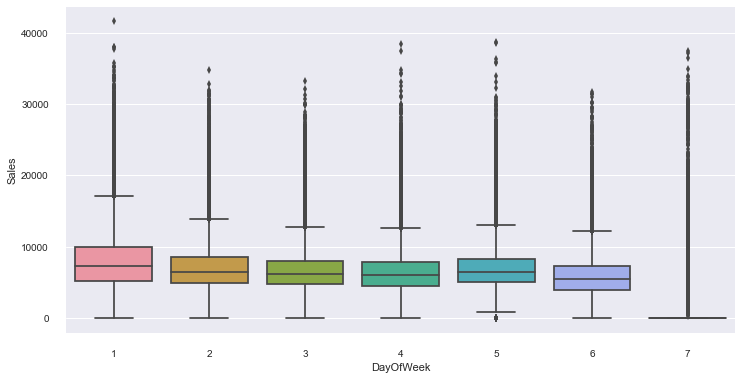

In [18]:
# total sales by day of week 

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(x="DayOfWeek", y="Sales",data=train[['Sales','DayOfWeek']])
sns.despine(offset=10, trim=True)

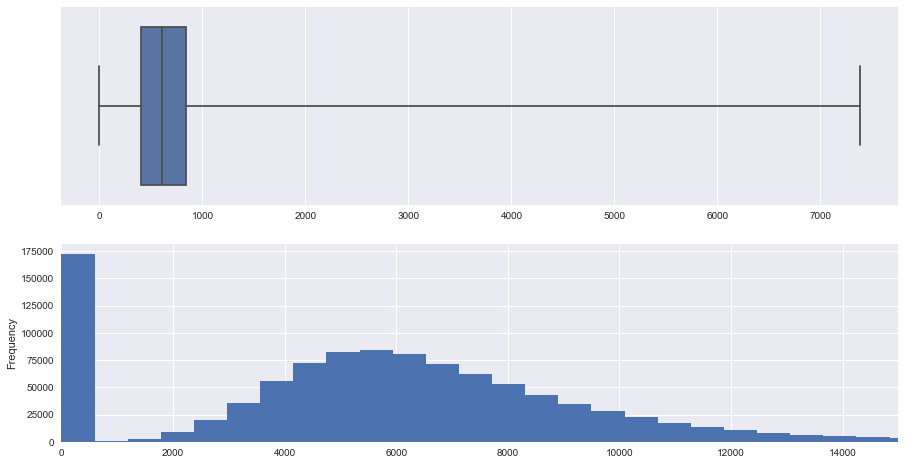

In [21]:
# Sales

fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,8))

# Plot max, min values, & 2nd, 3rd quartile
sns.boxplot([train["Customers"]], whis=np.inf, ax=axis1)

# Plot sales values 
# Notice that values with 0 is mostly because the store was closed
train["Sales"].plot(kind='hist',bins=70,xlim=(0,15000),ax=axis2)

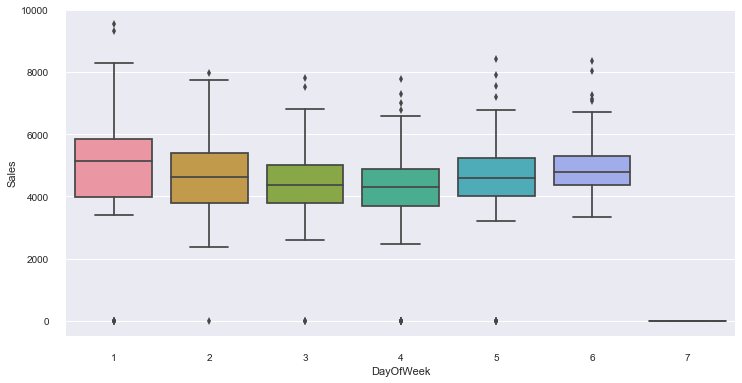

In [23]:
# only for store #1

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(x="DayOfWeek", y="Sales",data=train[['Sales','DayOfWeek']][train["Store"]==1])
sns.despine(offset=10, trim=True)

In [24]:
# total sales per store

train[['Store','Sales']].groupby('Store').sum().head()

# avg sales per store 

train[['Store','Sales']].groupby('Store').mean().head()

,Sales
Store,
1,3945.704883
2,4122.991507
3,5741.253715
4,8021.769639
5,3867.110403


In [26]:
train[['Store','SalePerCustomer']].groupby('Store').sum().head()


,SalePerCustomer
Store,
1,6554.962733
2,6592.219192
3,7102.609730
4,5683.864617
5,6708.147434


In [27]:
train[['Store','SalePerCustomer']].groupby('Store').mean().head()

,SalePerCustomer
Store,
1,8.393038
2,8.408443
3,9.117599
4,7.249827
5,8.611229


In [28]:
train_store = pd.merge(train, store, how = 'left', on = 'Store')
test_store = pd.merge(test, store, how = 'left', on = 'Store')


In [29]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [30]:
train_store.groupby('Assortment')['Sales'].describe()


,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,5481.026096,3682.766186,0.0,3492.0,5463.0,7514.00,38722.0
b,8294.0,8553.931999,3882.418206,0.0,5523.0,8026.5,11233.25,22137.0
c,471470.0,6058.676567,3992.255662,0.0,4017.0,6039.0,8184.00,41551.0


In [31]:
train_store.groupby('StoreType')['Customers', 'Sales'].mean()


,Customers,Sales
StoreType,,
a,659.034880,5738.179710
b,1987.720846,10058.837334
c,673.265894,5723.629246
d,501.434892,5641.819243


In [32]:
c = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

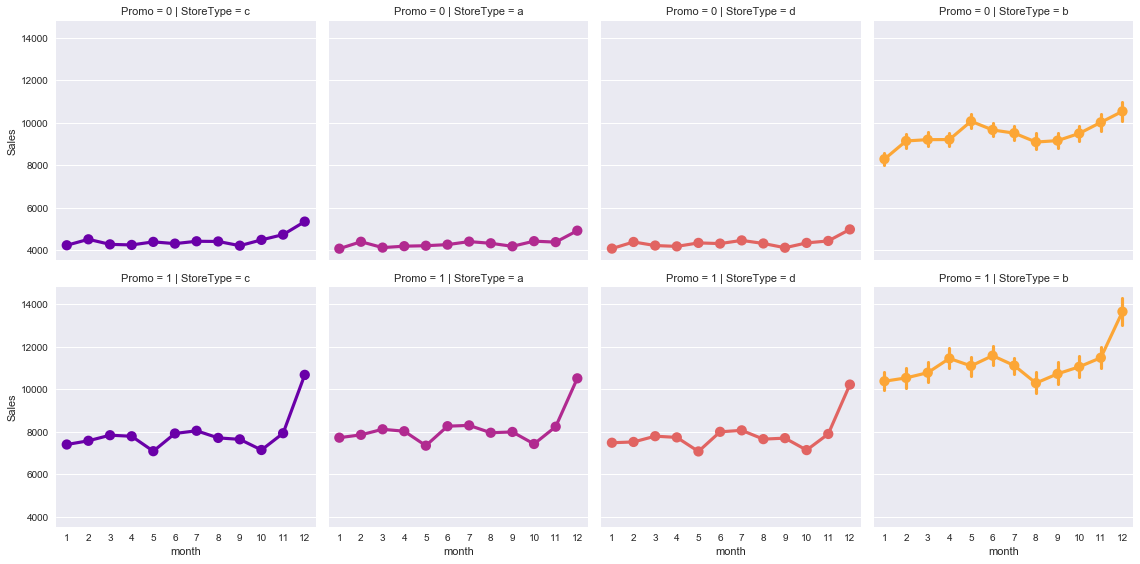

In [33]:
# sales trends
sns.factorplot(data = train_store, x = 'month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', 
               color = c,sharey=True) 

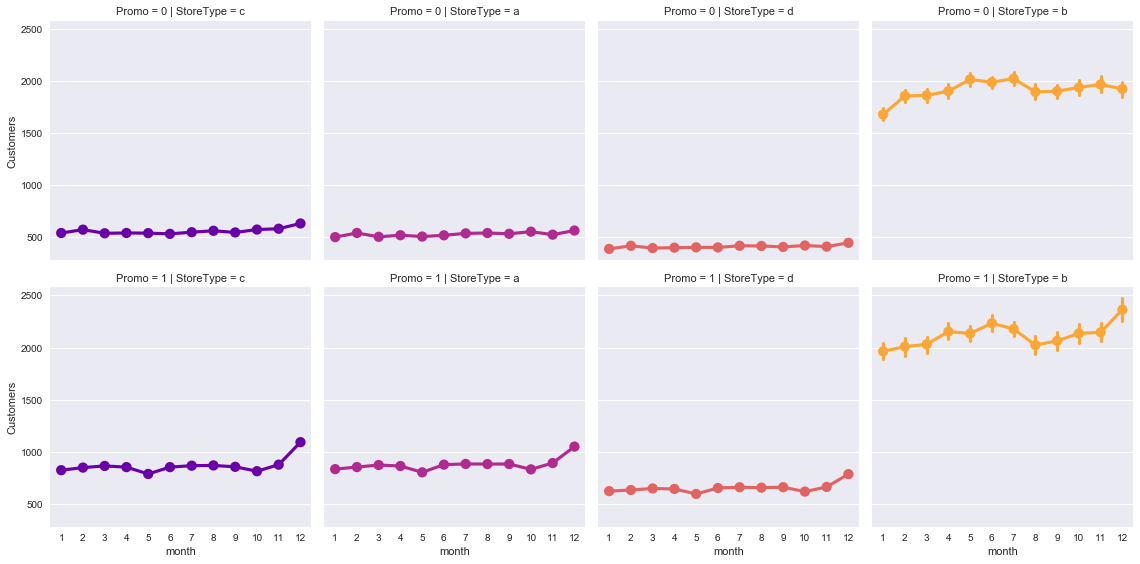

In [34]:
# customers trends
sns.factorplot(data = train_store, x = 'month', y = "Customers", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', 
               color = c,sharey=True) 

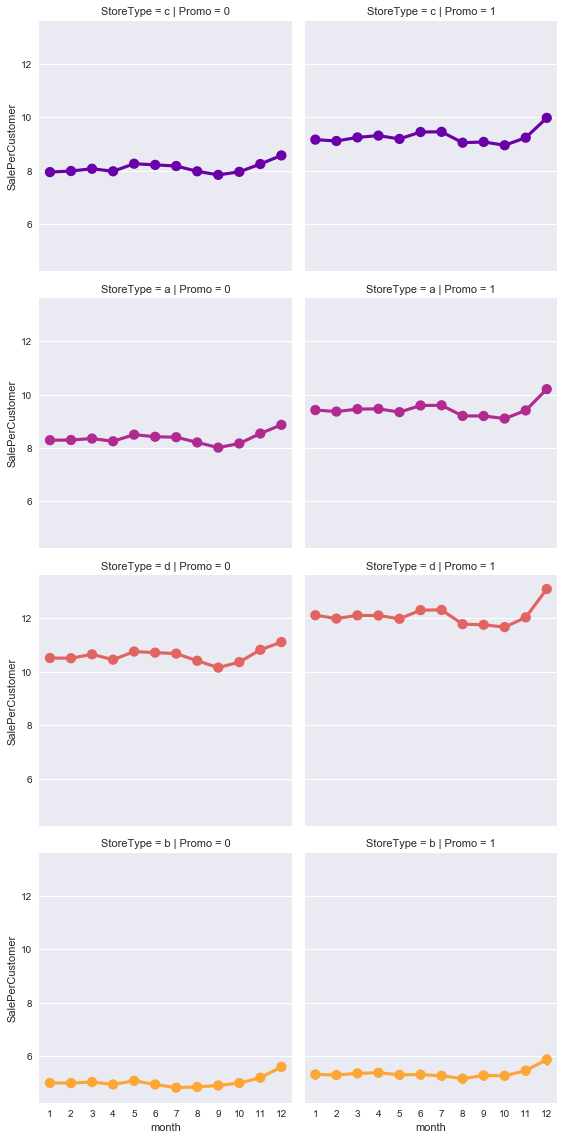

In [36]:
sns.factorplot(data = train_store, x = 'month', y = "SalePerCustomer", 
               col = 'Promo', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', 
               color = c,sharey=True) 

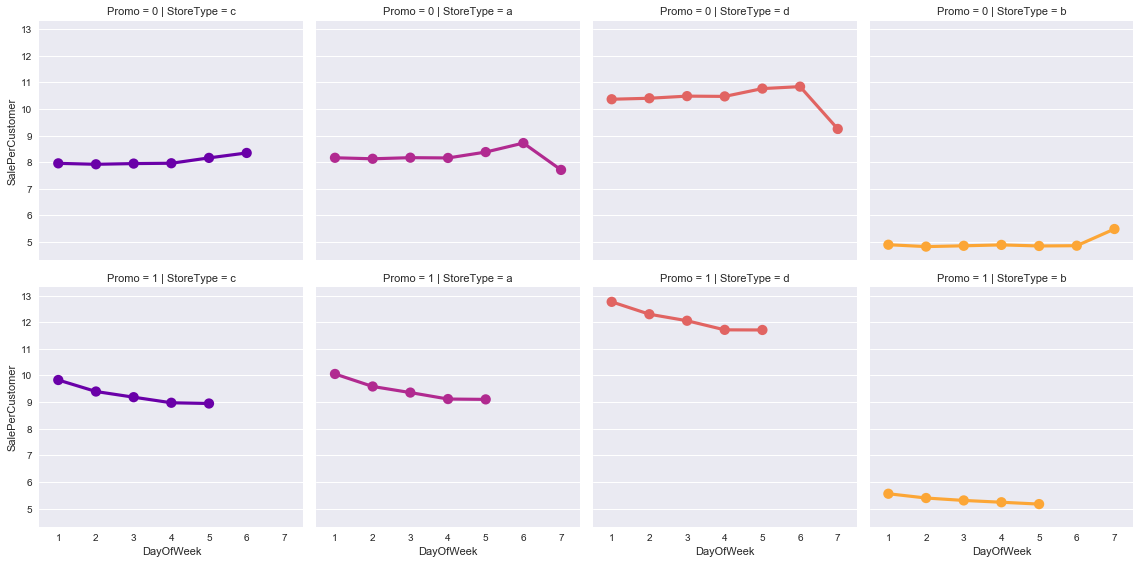

In [37]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "SalePerCustomer", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', 
               color = c,sharey=True) 

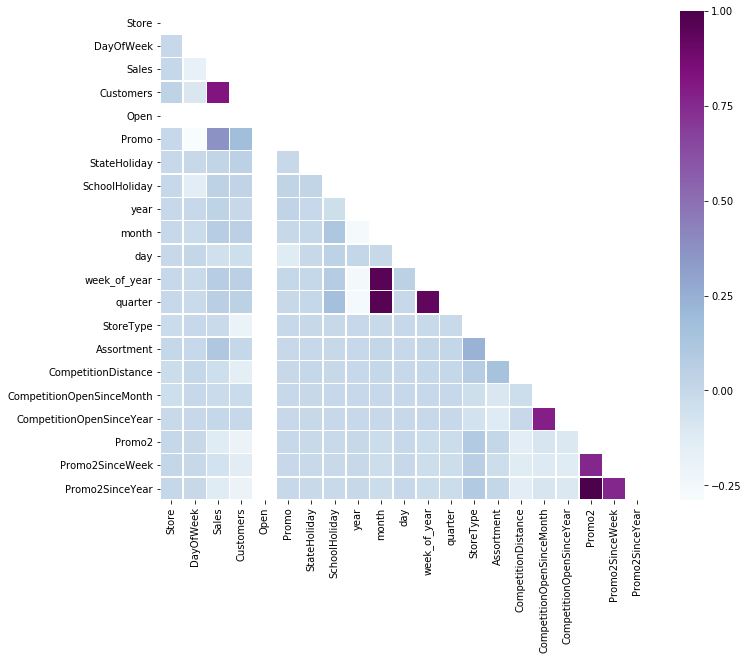

In [10]:
# features correlation

corr_all = train_store.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

In [ ]:
correlations = train_store.corr()['Sales'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(5))
print('\nMost Negative Correlations:\n', correlations.head(5))

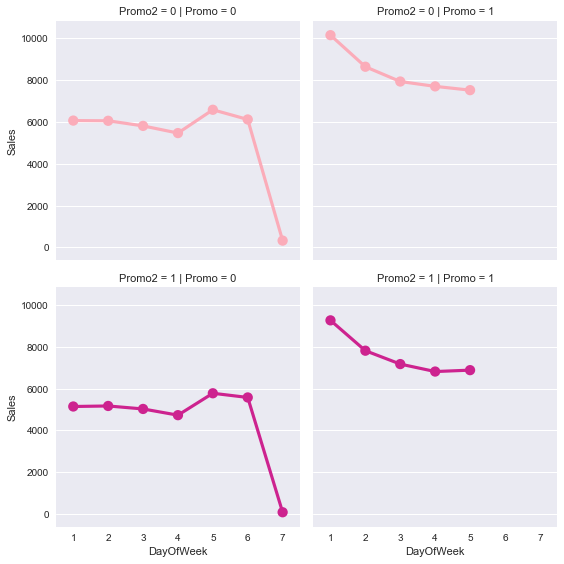

In [44]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

In [45]:
train.head()

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,year,month,day,DayOfWeek,week_of_year,quarter,SalePerCustomer
0,1,5263,555,1,1,0,1,2015-07-31,2015,7,31,5,31,3,9.482883
1,2,6064,625,1,1,0,1,2015-07-31,2015,7,31,5,31,3,9.702400
2,3,8314,821,1,1,0,1,2015-07-31,2015,7,31,5,31,3,10.126675
3,4,13995,1498,1,1,0,1,2015-07-31,2015,7,31,5,31,3,9.342457
4,5,4822,559,1,1,0,1,2015-07-31,2015,7,31,5,31,3,8.626118


<Figure size 576x360 with 0 Axes>

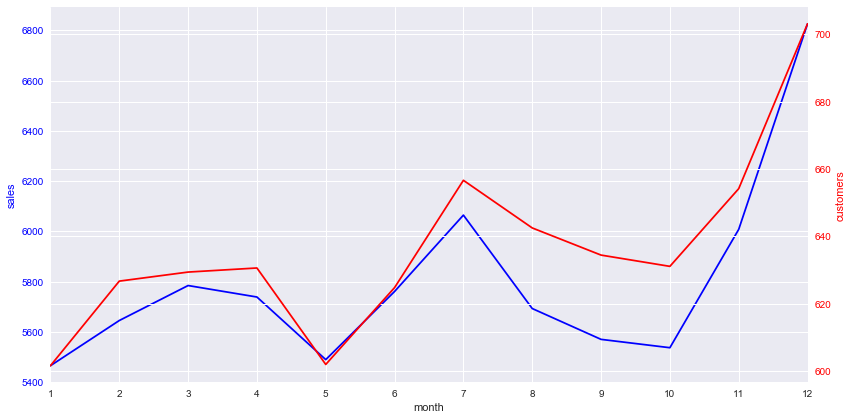

In [47]:
# avg customers and sales per month

average_sales_per_month = train_store.groupby('month')["Sales"].mean()
average_customers_per_month = train_store.groupby('month')['Customers'].mean()

plt.figure(figsize=(8, 5))

fig, ax1 = plt.subplots()

ax1.plot(average_sales_per_month,color='blue')
ax2 = ax1.twinx()
ax2.plot(average_customers_per_month,color = 'red')


ax1.set_xlabel('month')
ax1.set_xticks(average_sales_per_month.index, minor=False)
plt.xlim(1,12)
ax1.set_ylabel('sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel('customers', color='red') 
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

In [48]:
display(train_store.head(1),test_store.head(1))

,Store,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,year,month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5263,555,1,1,0,1,2015-07-31,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,year,month,...,quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,...,3,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [49]:
total_customers_for_store =  train_store.groupby('Store')['Sales', 'Customers'].sum()
average_sales_customers =  train_store.groupby('Store')['Sales', 'Customers'].mean()

data_stores_average = average_sales_customers.join(store.set_index('Store'), on='Store')
data_stores_new = total_customers_for_store.join(store.set_index('Store'), on='Store')

In [50]:
total_customers_for_store.head()
average_sales_customers.head()
data_stores_average.head()
data_stores_new.head()

,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,,,
1,3716854,440523,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,3883858,457855,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,5408261,584310,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,7556507,1036254,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
5,3642818,418588,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [51]:
test_store.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,year,month,...,quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,...,3,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


# general model

In [8]:
from sklearn import cross_validation
import xgboost as xgb

# weights

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

# evaluation function

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

# evaluation function for xgboost

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [9]:
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

In [10]:
# drop not needed columns 

train_store.drop(['Date','Open','PromoInterval','Customers'],axis=1,inplace =True)
test_store.drop(['Id','Date','Open','PromoInterval'],axis=1,inplace =True)

In [11]:


print("Train a XGBoost model")

X_train, X_test = cross_validation.train_test_split(train_store, test_size=10000, random_state=42)

dtrain = xgb.DMatrix(X_train.drop("Sales",axis=1), np.log(X_train["Sales"] + 1))
dvalid = xgb.DMatrix(X_test.drop("Sales",axis=1), np.log(X_test["Sales"] + 1))
dtest = xgb.DMatrix(test_store)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

gbm = xgb.train(params, dtrain, num_trees,
                evals=watchlist,
                early_stopping_rounds=100, # 100
                feval=rmspe_xg, verbose_eval=True)

Train a XGBoost model
[0]	eval-rmse:5.79716	train-rmse:5.79349	eval-rmspe:0.996854	train-rmspe:0.996845
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmse:4.06578	train-rmse:4.06252	eval-rmspe:0.981585	train-rmspe:0.981546
[2]	eval-rmse:2.85633	train-rmse:2.85324	eval-rmspe:0.938223	train-rmspe:0.938106
[3]	eval-rmse:2.01082	train-rmse:2.00791	eval-rmspe:0.85723	train-rmspe:0.857126
[4]	eval-rmse:1.42416	train-rmse:1.42156	eval-rmspe:0.744026	train-rmspe:0.744316
[5]	eval-rmse:1.01714	train-rmse:1.01481	eval-rmspe:0.618095	train-rmspe:0.619615
[6]	eval-rmse:0.740016	train-rmse:0.737562	eval-rmspe:0.499984	train-rmspe:0.503564
[7]	eval-rmse:0.552462	train-rmse:0.549215	eval-rmspe:0.40351	train-rmspe:0.410564
[8]	eval-rmse:0.431784	train-rmse:0.428232	eval-rmspe:0.336249	train-rmspe:0.347815
[9]	eval-rmse:0.347026	train-rmse:0.343134	eval-rmspe:0.288712	train-rmspe:0.306177
[10]

[96]	eval-rmse:0.108537	train-rmse:0.098061	eval-rmspe:0.11912	train-rmspe:0.133194
[97]	eval-rmse:0.108421	train-rmse:0.097904	eval-rmspe:0.118948	train-rmspe:0.133003
[98]	eval-rmse:0.108246	train-rmse:0.097703	eval-rmspe:0.11884	train-rmspe:0.132833
[99]	eval-rmse:0.108095	train-rmse:0.097483	eval-rmspe:0.118666	train-rmspe:0.132589
[100]	eval-rmse:0.107714	train-rmse:0.096987	eval-rmspe:0.118288	train-rmspe:0.132127
[101]	eval-rmse:0.107492	train-rmse:0.096676	eval-rmspe:0.118017	train-rmspe:0.131841
[102]	eval-rmse:0.107355	train-rmse:0.096474	eval-rmspe:0.117877	train-rmspe:0.131696
[103]	eval-rmse:0.107152	train-rmse:0.09616	eval-rmspe:0.117666	train-rmspe:0.131425
[104]	eval-rmse:0.10689	train-rmse:0.095822	eval-rmspe:0.117015	train-rmspe:0.130991
[105]	eval-rmse:0.106752	train-rmse:0.095612	eval-rmspe:0.116894	train-rmspe:0.130837
[106]	eval-rmse:0.106623	train-rmse:0.095378	eval-rmspe:0.116867	train-rmspe:0.130638
[107]	eval-rmse:0.106562	train-rmse:0.095207	eval-rmspe:0.1168

[192]	eval-rmse:0.098069	train-rmse:0.081106	eval-rmspe:0.10933	train-rmspe:0.090494
[193]	eval-rmse:0.098017	train-rmse:0.081014	eval-rmspe:0.109277	train-rmspe:0.090332
[194]	eval-rmse:0.097975	train-rmse:0.080911	eval-rmspe:0.109285	train-rmspe:0.090207
[195]	eval-rmse:0.097919	train-rmse:0.080756	eval-rmspe:0.109221	train-rmspe:0.088728
[196]	eval-rmse:0.097844	train-rmse:0.080581	eval-rmspe:0.109177	train-rmspe:0.088531
[197]	eval-rmse:0.097811	train-rmse:0.080503	eval-rmspe:0.109144	train-rmspe:0.088457
[198]	eval-rmse:0.097847	train-rmse:0.080439	eval-rmspe:0.109216	train-rmspe:0.088388
[199]	eval-rmse:0.097788	train-rmse:0.080389	eval-rmspe:0.10911	train-rmspe:0.088341
[200]	eval-rmse:0.097759	train-rmse:0.080284	eval-rmspe:0.109069	train-rmspe:0.088228
[201]	eval-rmse:0.097696	train-rmse:0.080182	eval-rmspe:0.10901	train-rmspe:0.088123
[202]	eval-rmse:0.097628	train-rmse:0.080073	eval-rmspe:0.108946	train-rmspe:0.087987
[203]	eval-rmse:0.097582	train-rmse:0.079979	eval-rmspe:0

[288]	eval-rmse:0.094708	train-rmse:0.072677	eval-rmspe:0.105236	train-rmspe:0.077301
[289]	eval-rmse:0.094704	train-rmse:0.072653	eval-rmspe:0.105227	train-rmspe:0.077273
[290]	eval-rmse:0.094662	train-rmse:0.072571	eval-rmspe:0.105193	train-rmspe:0.077189
[291]	eval-rmse:0.094641	train-rmse:0.072497	eval-rmspe:0.105167	train-rmspe:0.077081
[292]	eval-rmse:0.09463	train-rmse:0.072444	eval-rmspe:0.105158	train-rmspe:0.077021
[293]	eval-rmse:0.094588	train-rmse:0.072341	eval-rmspe:0.105083	train-rmspe:0.076866
[294]	eval-rmse:0.094556	train-rmse:0.072268	eval-rmspe:0.104992	train-rmspe:0.076746
[295]	eval-rmse:0.094547	train-rmse:0.072194	eval-rmspe:0.105019	train-rmspe:0.076659
[296]	eval-rmse:0.094534	train-rmse:0.072133	eval-rmspe:0.105006	train-rmspe:0.07659
[297]	eval-rmse:0.094536	train-rmse:0.072089	eval-rmspe:0.105015	train-rmspe:0.076543
[298]	eval-rmse:0.094503	train-rmse:0.072025	eval-rmspe:0.104998	train-rmspe:0.076465
[299]	eval-rmse:0.094472	train-rmse:0.071963	eval-rmspe:

In [12]:
# validation 

train_probs = gbm.predict(xgb.DMatrix(X_test.drop("Sales",axis=1)))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('error', error)

# prediction
test_probs = gbm.predict(dtest)

error 0.1049579227313887


In [64]:
indices = test_probs < 0
test_probs[indices] = 0
closed_idx = (test['Open']==0).values
test_probs[closed_idx] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
#submission.to_csv("xgboost_submit.csv", index=False)

In [65]:
submission.head()

,Id,Sales
0,1,4021.856445
1,2,7613.400879
2,3,8785.064453
3,4,7511.954590
4,5,7566.642090


# per store model

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [46]:
aaa = dict(list(train_store.groupby('Store')))
bbb = dict(list(test_store.groupby('Store')))

In [17]:
X_train, X_test ,y_train,y_test= train_test_split(train_store.drop("Sales",axis=1),train_store["Sales"], test_size=10000, random_state=42)


In [21]:
print(y_train.shape)
print(y_test.shape)
y_train.head()

(834338,)
(10000,)


504086     4457
525685    13169
525747     6464
93457      5275
513324     7511
Name: Sales, dtype: int64

In [47]:
# predict 
#['Date','Open','PromoInterval','Customers']

result = pd.Series()
for i in bbb:  
    store = aaa[i]
    X_train = store.drop(["Date","Sales",'PromoInterval',  "Customers"],axis=1)
    Y_train = store["Sales"]
    X_test  = bbb[i].copy()   
    store_ind = X_test["Id"]
    X_test.drop(["Id",'PromoInterval'], axis=1,inplace=True)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())
    estimator = RandomForestRegressor(n_estimators=10, max_depth=13, criterion = 'mse')
    estimator.fit(X_train, Y_train)
    Y_pred = estimator.predict(X_test.drop("Date",axis=1))
    result = result.append(pd.Series(Y_pred, index=store_ind))
#result = result.append(pd.Series(0, index=closed_store_data))
result = pd.DataFrame({ "Id": result.index, "Sales": result.values})
#result.to_csv('result_new.csv', index=False)


In [49]:
result

,Id,Sales
0,1,4504.397826
1,857,4601.897826
2,1713,4860.200000
3,2569,5430.300000
4,3425,4216.428651
5,4281,4183.168651
6,5137,3726.446429
7,5993,3476.929420
8,6849,3462.650000
9,7705,3631.116667


# times series

In [ ]:
c = 'blue'


In [ ]:
#seasonality

# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

a = train[train.Store == 2][['Date','Sales']].set_index('Date')
a.index = a.index.astype('datetime64[ns]')
sales_a = a


b = train[train.Store == 1][['Date','Sales']].set_index('Date')
b.index = b.index.astype('datetime64[ns]')
sales_b = b


f, (ax1, ax2) = plt.subplots(2, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)


In [ ]:
# yearly trend
from statsmodels.tsa.seasonal import seasonal_decompose

f, (ax1, ax2) = plt.subplots(2, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

In [ ]:
#auto correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A

plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

In [ ]:
# ARIMA


In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


val = validation.Sales.tolist()
history = [x for x in dataset.values]
predictions = list()
for t in range(len(val)):
	model = ARIMA(history,order=(7,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = val[t]
	history.append(obs)
	print('predicted=%f, real value=%f' % (yhat, obs))
error = mean_squared_error(val, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(val)
pyplot.plot(predictions, color='red')
plt.xlabel('day')
plt.ylabel('sales')
pyplot.show()

In [ ]:
Test MSE: 517798.078


# ML Loop for each store


In [ ]:
# sales of store 1 
aaa = train[train.Sales>0]
aaa.loc[aaa['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

In [ ]:
bbb = aaa.loc[train['Store']==1]
bbb.head()

bbb_test = bbb.head(10)
bbb_train =  bbb.iloc[10:]


display(bbb_test.tail(),bbb_train.head())

In [ ]:
dataset = bbb_train[['Date','Sales']].set_index('Date')
validation = bbb_test[['Date','Sales']].set_index('Date')

In [ ]:
#LSTM

In [ ]:
dataset = bbb_train[['Date','Sales']].set_index('Date')
validation = bbb_test[['Date','Sales']].set_index('Date')

dataset.head()